<a href="https://colab.research.google.com/github/ananthu-raj/Image-Classification-Experimentation/blob/main/Chess_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chess Image Classification**

In [16]:
# Importing libraries
#!pip install tensorflow-gpu
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [1]:
# Checking the GPU Version
!nvidia-smi

Thu Nov 10 11:56:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

['/content/drive/MyDrive/Chess/pawn_resized', '/content/drive/MyDrive/Chess/Rook-resize', '/content/drive/MyDrive/Chess/Queen-Resized', '/content/drive/MyDrive/Chess/bishop_resized', '/content/drive/MyDrive/Chess/knight-resize']


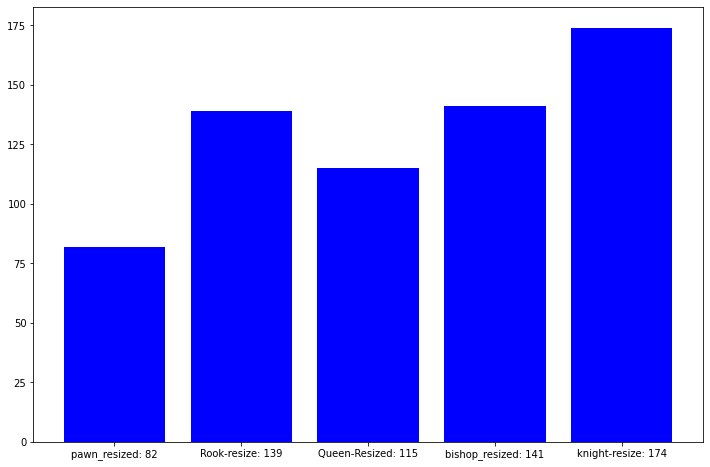

In [11]:
# To visualise the number of each chess pieces
dirname = '/content/drive/MyDrive/Chess'
dir_chess_folders = os.listdir(dirname)
dir_chess_paths = [os.path.join(dirname, path) for path in dir_chess_folders]
print(dir_chess_paths)

chess_dic = {}
for path in dir_chess_paths:
    head, tail = os.path.split(path)
    chess_dic[tail] = len(os.listdir(path))
label_list = ["{}: {}".format(key, chess_dic[key]) for key in chess_dic]
plt.figure(figsize=(12, 8))
plt.bar(range(len(chess_dic)), list(chess_dic.values()), color="blue")
plt.xticks(range(len(chess_dic)), list(label_list))
plt.show();

# CNN

In [20]:
# Resizing different resolution images to a common resolution
img_size_h = 350
img_size_w = 350

# Normalizing RGB pixel values between 0 and 1
train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.3)
input_shape = (img_size_h, img_size_w, 3)
batch_size = 16

# Splitting the data into training and test sets
train_generator = train_datagen.flow_from_directory(
    dirname,
    target_size=(img_size_h, img_size_w),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,  # we shuffle our images for better performance
    seed=8)
validation_generator = train_datagen.flow_from_directory(
    dirname,
    target_size=(img_size_h, img_size_w),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=7)

Found 458 images belonging to 5 classes.
Found 193 images belonging to 5 classes.
